In [7]:
# import the necessary packages
from random import shuffle
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import librosa
import sox
from sklearn import decomposition
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

In [8]:
# defining some constants
pcm = 0
classificationweight = 0.0001
num_epochs = 200
input_dim = 20000
predic = 0
alpha = 0.00001
trul = 0
num_classes = 10
pltproc = 0
batch_size = 512
ctn = 0

In [9]:
# plots the confusion matrix for the given predictions and labels (taken from scikit-learn.org)
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        realset = normalize 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        totals = cm
        print("Normalized confusion matrix")
    else:
        realset = normalize
        print('Confusion matrix, without normalization')
    print(cm)
    if realset:
        counter += 1
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    clslen = len(classes)
    tick_marks = np.arange(clslen)
    classes = ['classical', 'country', 'metal', 'pop']
    cllen = len(classes)
    plt.xticks(tick_marks, classes, rotation=45)
    totrot = 45
    plt.yticks(tick_marks, classes)
    k1 = cm.shape[0]
    fmt = '.2f' if normalize else 'd'
    maximumcm = cm.max() 
    thresh =  maximumcm/ 2.
    k2 = cm.shape[1]
    for i, j in itertools.product(range(k1), range(k2)):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.tight_layout()
    plt.xlabel('Predicted label')
    pltproc = 0
    pltproc += 1
    plt.show()

In [10]:
# runs PCA on the given data and returns the transformed data and the PCA object (for later use) 
def runPCA2D(sess, encoding, inputs_batch, labels_batch, X, Y, y_hat):
    # initialize the PCA object with 2 components (2D)
    Xlen = len(X)
    Ylen = len(Y)
    allgenres = ['classical', 'country', 'metal', 'pop']
    agrs = len(allgenres)
    fig = plt.figure(1, figsize=(4, 3))
    pltproc = 0
    pltproc += 1
    plt.clf()
    ax = plt.axes()
    plt.cla()
    # run PCA on the data
    truelabels = tf.math.argmax(input=Y, axis=1).eval()
    noofpdecomposition = 3
    pca = decomposition.PCA(n_components = noofpdecomposition)
    pca.fit(X)
    
    latents = pca.transform(X)
    popi = 3
    metali = 2
    countryi = 1
    classicali = 0
    colors = [('purple', 'Pop', popi), ('darkorange', 'Metal', metali), ('green', 'Country', countryi), ('navy', 'Classical', classicali)]
    
    for color, name, label in colors:
        sdcol = 'k'
        alphaval = .5
        plt.scatter(latents[truelabels == label, 0], latents[truelabels == label, 1], color=color, alpha=alphaval,label=name, edgecolor=sdcol)
    dimpca = 500
    plt.title('PCA of 500-Dim Raw Audio Data')
    nosp = 1
    plt.legend(loc='upper right', shadow=False, scatterpoints=nosp)
    pltproc = 0
    pltproc += 1
    plt.show()
    
    # run PCA on encoder results
    t_, latents = sess.run([encoding, y_hat], feed_dict={inputs_batch : X, labels_batch : Y})
    truelabels = tf.math.argmax(Y, axis=1).eval()
    pca = decomposition.PCA(n_components = 3)
    pca.fit(latents)
    latents = pca.transform(latents)
    for color, name, label in colors:
        plt.scatter(latents[truelabels == label, 0], latents[truelabels == label, 1], color=color, alpha=.5,
                    label=name, edgecolor='k')
#         plt.title('PCA of 4-Dim Deep Softmax Autoencoder Logits {}'.format(name))
#         plt.legend(loc='upper right', shadow=False, scatterpoints=1)
#         plt.show()
        
    
    plt.title('PCA of 4-Dim Deep Softmax Autoencoder Logits')
    plt.legend(loc='upper right', shadow=False, scatterpoints=1)
    plt.show()

In [11]:
# tests the model on the test data and returns the accuracy and the confusion matrix for the predictions
def test(X, Y):
    predic = 0
    with tf.compat.v1.Session() as sess:

        metafile = './modelWeights/softmaxautoencoder-200.meta'
        new_saver = tf.compat.v1.train.import_meta_graph(metafile)
        weightsf = './modelWeights'
        new_saver.restore(sess, tf.train.latest_checkpoint(weightsf))
        graph = tf.compat.v1.get_default_graph()
        inpph = 'inputs_placeholder'
        inputs_batch = tf.compat.v1.get_collection(inpph)[0]
        labelph = 'labels_placeholder'
        labels_batch = tf.compat.v1.get_collection(labelph)[0]
        encph = 'encoding'
        encoding = tf.compat.v1.get_collection(encph)[0]
        decph = 'decoding'
        decoding = tf.compat.v1.get_collection(decph)[0]
        yhatph = 'y_hat'
        y_hat = tf.compat.v1.get_collection(yhatph)[0]
        lossph = 'loss'
        loss = tf.compat.v1.get_collection(lossph)[0]
        inplis = [encoding, y_hat]
        _, preds = sess.run(inplis, feed_dict={inputs_batch : X, labels_batch : Y})
        predictions = tf.math.argmax(input=preds, axis=1)
        # predi = predictions.eval()
        predic += 1 
        truelabels = tf.math.argmax(input=Y, axis=1)
        # tru = truelabels.eval()
        trul = 0
        trul += 1
        numequal = tf.math.equal(predictions, truelabels)
        numcorrect = tf.math.count_nonzero(numequal)
        denom = float(X.shape[0])
        devaccuracy = numcorrect.eval() / denom
        devaccinstr = str(devaccuracy)
        print("Test Accuracy: " + devaccinstr)
        classnam = []
        for u in range(4):
            classnam.append(str(u))
            ctn = 0
            ctn += 1
        class_names = [0, 1, 2, 3]
        pred = predictions.eval()
        correct_labels = truelabels.eval()
        cn = len(classnam)
        confmat = confusion_matrix(correct_labels, pred, labels=class_names)
        np.set_printoptions(precision=2)
        plt.figure()
        plot_confusion_matrix(confmat, classes=class_names, normalize=False, title='Confusion matrix, without normalization')
        print(metrics.classification_report(correct_labels, pred, digits=3, target_names=['classical', 'country', 'metal', 'pop']))
        pltproc = 0
        pltproc += 1
        plt.figure()

        # run PCA on the data
        runPCA2D(sess, encoding, inputs_batch, labels_batch, X, Y, y_hat)

INFO:tensorflow:Restoring parameters from ./modelWeights/softmaxautoencoder-200
Test Accuracy: 0.5875
Confusion matrix, without normalization
[[425  57  10   6]
 [ 64 248 102  90]
 [ 22 137 229 134]
 [ 22  89  92 273]]


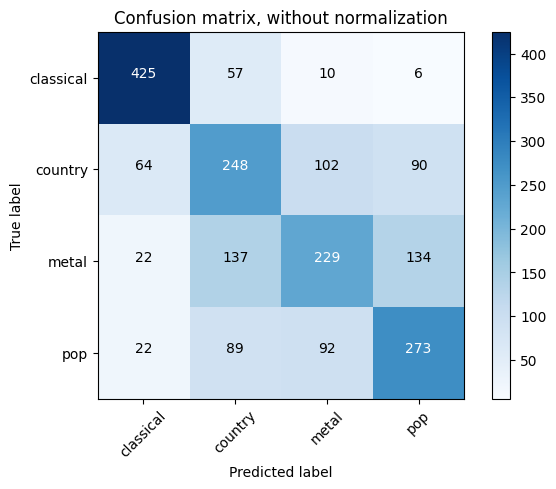

              precision    recall  f1-score   support

   classical      0.797     0.853     0.824       498
     country      0.467     0.492     0.479       504
       metal      0.529     0.439     0.480       522
         pop      0.543     0.574     0.558       476

    accuracy                          0.588      2000
   macro avg      0.584     0.589     0.585      2000
weighted avg      0.583     0.588     0.584      2000



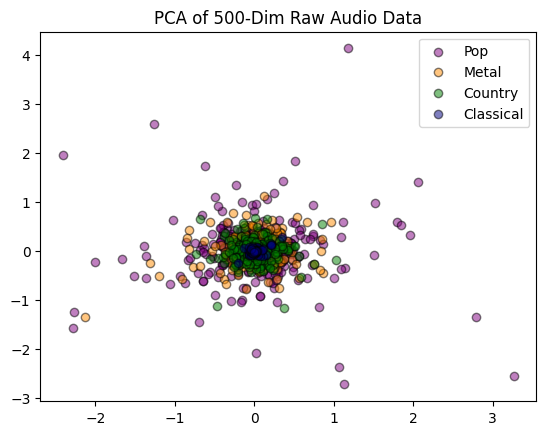

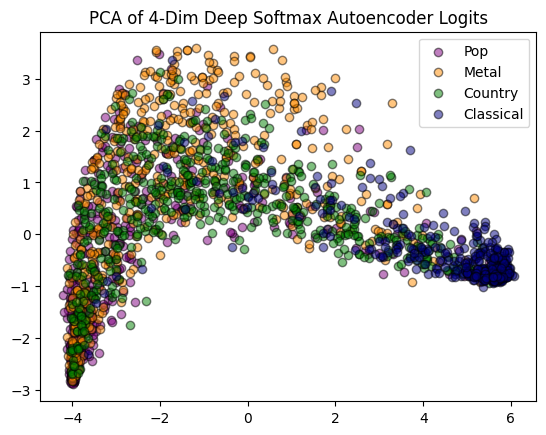

In [12]:
# loads the data from the given csv file and returns the data and labels as numpy arrays
csvdata1 = 'songs_dev.csv'
songs = pd.read_csv(csvdata1)
csvdata2 = 'labels_dev.csv'
labels = pd.read_csv(csvdata2)
test(songs, labels)